<a href="https://colab.research.google.com/github/ksailesh/housing_price_project/blob/main/Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read the Datasets

In [20]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive/')

df_enriched_features_file_path = '/content/drive/MyDrive/Colab Notebooks/df_enriched_features.pkl'
df_without_enriched_features_file_path = '/content/drive/MyDrive/Colab Notebooks/df_without_enriched_features.pkl'
try:
  df_enriched_features = pd.read_pickle(df_enriched_features_file_path)
  display(df_enriched_features.dtypes)
  df_without_enriched_features = pd.read_pickle(df_without_enriched_features_file_path)
  display(df_without_enriched_features.dtypes)
  print("Successfully loaded the pickle files.")
except FileNotFoundError:
  print(f"Error: File not found at {df_enriched_features_file_path}. Please check the file path.")
  print(f"Error: File not found at {df_without_enriched_features_file_path}. Please check the file path.")
except Exception as e:
  print(f"An error occurred: {e}")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,0
longitude,float64
latitude,float64
housing_median_age,int64
total_rooms,int64
total_bedrooms,Int64
population,int64
households,int64
median_income,float64
median_house_value,int64
rooms_per_household,float64


,0
longitude,float64
latitude,float64
housing_median_age,int64
total_rooms,int64
total_bedrooms,Int64
population,int64
households,int64
median_income,float64
median_house_value,int64
ocean_proximity_INLAND,bool


Successfully loaded the pickle files.


# 1a. Random Forest Model - Version 1

In [21]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

X = df_enriched_features.drop('median_house_value', axis=1)
y = df_enriched_features['median_house_value']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler= StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the RandomForestRegressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42) # You can adjust hyperparameters
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test_scaled)

# 1b. Evaluate Model Performance


In [22]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2 Score: {r2}")


Root Mean Squared Error (RMSE): 50410.54593823026
R2 Score: 0.8118039963396423


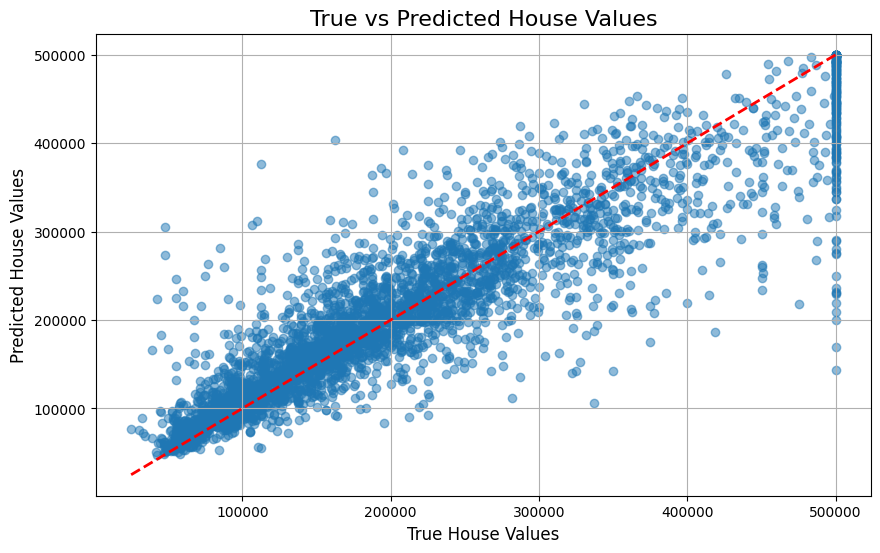

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title("True vs Predicted House Values", fontsize=16)
plt.xlabel("True House Values", fontsize=12)
plt.ylabel("Predicted House Values", fontsize=12)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--", lw=2)
plt.grid(True)
plt.show()

# 2a. Random Forest Model - Version 2

In [24]:
# Check for Multicollinearity using VIF
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import numpy as np
import statsmodels.api as sm

df_enriched_features.loc[:, 'income_x_population'] = df_enriched_features['median_income'] * df_enriched_features['population_per_household']
df_enriched_features.loc[:, 'pop_x_bedroom_ratio'] = df_enriched_features['population_per_household'] * df_enriched_features['bedrooms_per_room']
df_enriched_features.loc[:, 'rooms_x_bedrooms'] = df_enriched_features['rooms_per_household'] * df_enriched_features['bedrooms_per_household']
df_enriched_features.loc[:, 'income_x_ocean_proximity'] = df_enriched_features['median_income'] * df_enriched_features['ocean_proximity_INLAND']
df_enriched_features.loc[:, 'ocean_x_rooms'] = df_enriched_features['ocean_proximity_NEAR OCEAN'] * df_enriched_features['rooms_per_household']
df_enriched_features.loc[:, 'ocean_x_rooms'] = df_enriched_features['ocean_proximity_NEAR OCEAN'] * df_enriched_features['rooms_per_household']

# Define the independent and dependent variables
X = df_enriched_features[[
                          'longitude', 'latitude',
                          # 'ocean_proximity_NEAR OCEAN', 'rooms_per_household', 'pop_x_bedroom_ratio',
                          # 'income_per_population',  'rooms_x_bedrooms',  'ocean_proximity_INLAND', 'income_x_population',
                          'housing_median_age', 'households', 'median_income', 'ocean_proximity_NEAR BAY', 'income_x_ocean_proximity',
                          'bedrooms_per_room', 'population_per_household', 'bedrooms_per_household', 'ocean_x_rooms'
                          ]]

# Extract the target variable and Apply Log Tranformation
y = df_enriched_features['median_house_value']
# y = np.log(df_enriched_features['median_house_value'])

# Convert object columns to numeric using pd.to_numeric
for col in X.select_dtypes(include=['object']).columns:
    X[col] = pd.to_numeric(X[col], errors='coerce') # errors='coerce' will replace invalid values with NaN

# Explicitly convert all columns in X and y to numeric dtypes
X = X.astype(float) # Convert all columns in X to float
y = y.astype(float) # Convert y to float

X = X.dropna() # Drop rows with NaN values
y = y[X.index] # Align y with X after dropping rows

# Add a constant to the independent variables (intercept term)
X = sm.add_constant(X)

# Compute VIF for each feature
vif_df = pd.DataFrame()
vif_df["Feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF values
print(vif_df)

# Identify and remove highly correlated predictors (e.g., VIF > 10)
high_vif_features = vif_df[vif_df["VIF"] > 16]["Feature"].tolist()

#Remove constant
if 'const' in high_vif_features:
  high_vif_features.remove('const')

print("\nHighly correlated features (VIF > 10):", high_vif_features)

# Remove the highly correlated features from X
X = X.drop(high_vif_features, axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler= StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the RandomForestRegressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42) # You can adjust hyperparameters
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test_scaled)

                     Feature           VIF
0                      const  27676.798560
1                  longitude     14.596962
2                   latitude     15.311633
3         housing_median_age      1.323681
4                 households      1.160597
5              median_income      1.813561
6   ocean_proximity_NEAR BAY      1.534794
7   income_x_ocean_proximity      1.900154
8          bedrooms_per_room      1.768887
9   population_per_household      1.044964
10    bedrooms_per_household      1.134425
11             ocean_x_rooms      1.192303

Highly correlated features (VIF > 10): []


# 2b. Evaluate Model Performance

In [25]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2 Score: {r2}")


Root Mean Squared Error (RMSE): 50064.56765107689
R2 Score: 0.8143783899299518


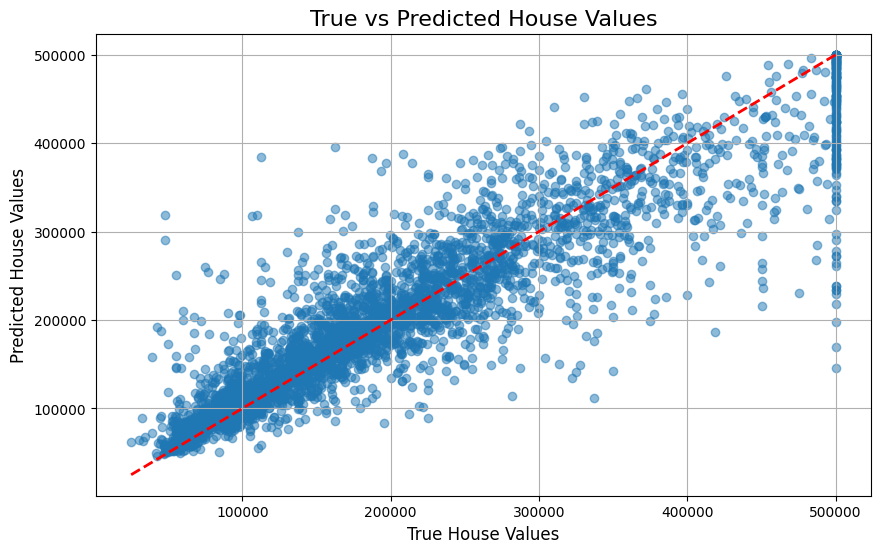

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title("True vs Predicted House Values", fontsize=16)
plt.xlabel("True House Values", fontsize=12)
plt.ylabel("Predicted House Values", fontsize=12)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--", lw=2)
plt.grid(True)
plt.show()